In [1]:
!pip install fair-esm  # latest release, OR:
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/esm.git  # bleeding edge, current repo main branch
#-----------------------#
!pip install "fair-esm[esmfold]"
# OpenFold and its remaining dependency
!pip install 'dllogger @ git+https://github.com/NVIDIA/dllogger.git'
!pip install -q git+https://github.com/aqlaboratory/openfold.git@3bec3e9b2d1e8bdb83887899102eff7d42dc2ba9

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-e5ewrd4y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-e5ewrd4y
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/NVIDIA/dllogger.git to /tmp/pip-install-t3naxkch/dllogger_6086fe20f23a4a198abbd0ec29011cb1
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/dllogger.git /tmp/pip-install-t3naxkch/dllogger_6086fe20f23a4a198abbd0ec29011cb1
  Resolved https://github.com/NVIDIA/dllogger.git to commit 0540a43971f4a8a16693a9de9de73c1072020769
  Preparing metadata (setup.py) ... done
  Created wheel for dllogger: filename=DLLogger-1.0.0-py3-none-any.whl size=5654 sha256=493a6ed81c62c06464ad3b63901a52e09d0

In [2]:
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


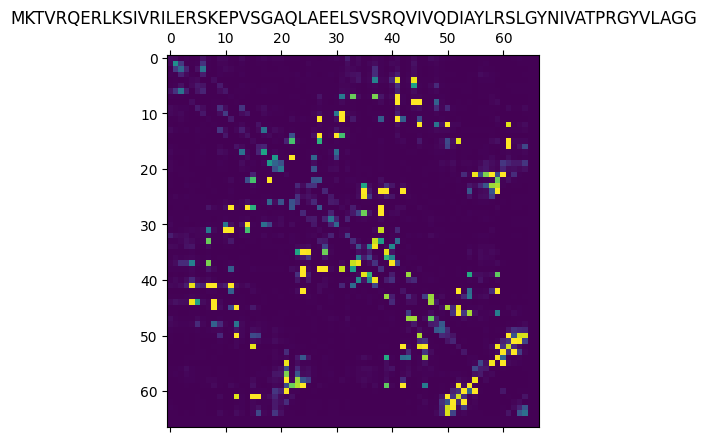

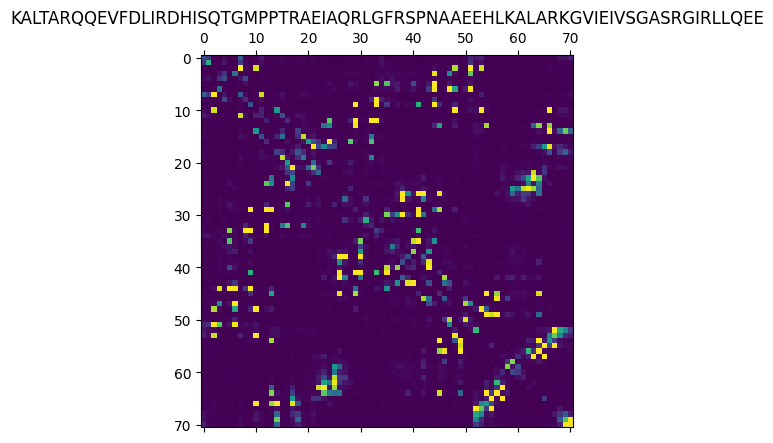

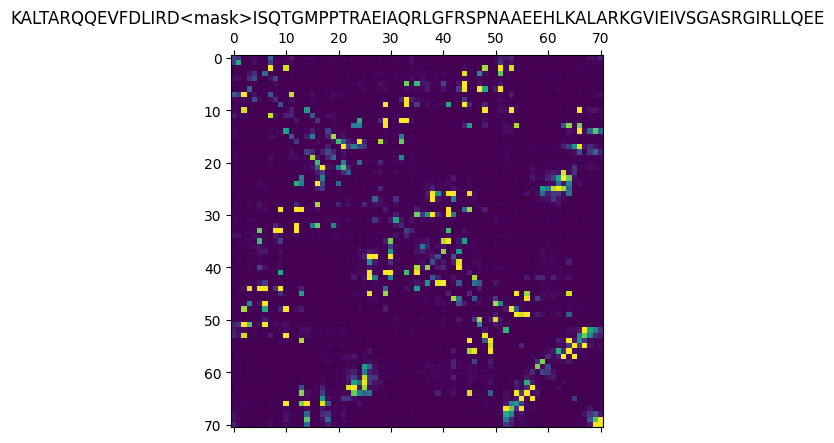

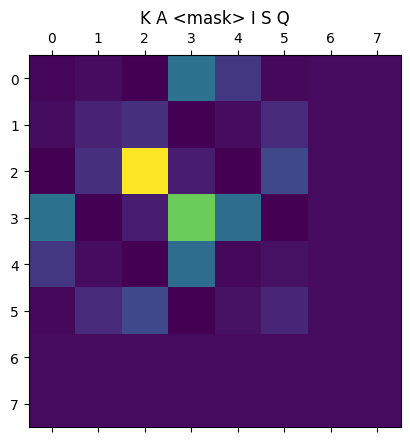

In [3]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, tokens_len in enumerate(batch_lens):
    sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0))

# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [1]:
!pip install modelcif
!pip install biotite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 13.9 MB/s eta 0:00:00


In [ ]:
import torch
import esm

model = esm.pretrained.esmfold_v1()
model = model.eval().cuda()

# Optionally, uncomment to set a chunk size for axial attention. This can help reduce memory.
# Lower sizes will have lower memory requirements at the cost of increased speed.
# model.set_chunk_size(128)

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"
# Multimer prediction can be done with chains separated by ':'

with torch.no_grad():
    output = model.infer_pdb(sequence)

with open("result.pdb", "w") as f:
    f.write(output)

import biotite.structure.io as bsio
struct = bsio.load_structure("result.pdb", extra_fields=["b_factor"])
print(struct.b_factor.mean())  # this will be the pLDDT
# 88.3